## 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from tools.utils import download_data, read_csv_by_pattern, run_mean_reversion_analysis
warnings.filterwarnings("ignore")

C:\Users\QueLe\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


## 2. Functions

In [2]:
# MR strength classification logic
def classify_mean_reversion(row):
    if row['ADF p-value'] < 0.01 and row['Hurst'] < 0.4 and row['Half-life'] < 10:
        return 'Strong'
    elif row['ADF p-value'] < 0.05 and row['Hurst'] < 0.5 and row['Half-life'] < 50:
        return 'Weak'
    else:
        return 'None'

In [3]:
# Strategy and Backtest
def mean_reversion_strategy_individual(prices, window, entry_z=1.5, exit_z=0.5):
    mean = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std().replace(0, 1e-10)
    z_scores = (prices - mean) / std
    signals = pd.Series(0, index=prices.index)
    signals[z_scores < -entry_z] = 1
    signals[z_scores > entry_z] = -1
    signals[(z_scores < exit_z) & (z_scores > -exit_z)] = 0
    return signals

def get_transaction_cost(volatility):
    if volatility < 0.01:
        return 0.0005
    elif volatility < 0.05:
        return 0.001
    else:
        return 0.002

def backtest_strategy(prices, signals, transaction_cost):
    # shifted_signals = signals.shift(1).fillna(0)
    positions = signals.ffill().shift(1).fillna(0)
    daily_log_returns = prices.diff().fillna(0)
    strategy_log_returns = positions * daily_log_returns

    # Transaction costs for the strategy
    trades = positions.diff().abs().fillna(0)
    cost_penalty = trades * transaction_cost
    strategy_log_returns -= cost_penalty


    # Buy & Hold benchmark (single round-trip cost)
    buy_and_hold_position = 1
    buy_and_hold_log_return = buy_and_hold_position * daily_log_returns
    buy_and_hold_trade_cost = 2 * transaction_cost
    buy_and_hold_log_return[0] -= buy_and_hold_trade_cost


    return strategy_log_returns, buy_and_hold_log_return

def calculate_performance(log_returns):
    total_log_return = log_returns.sum()
    annualized_return = total_log_return * (252 / len(log_returns))
    annualized_volatility = log_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan
    cumulative = log_returns.cumsum()
    running_max = cumulative.cummax()
    drawdown = cumulative - running_max
    max_drawdown = drawdown.min()
    return pd.DataFrame([{
        "Total Log Return": total_log_return,
        "Annualized Log Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": 1 - np.exp(max_drawdown),
        "Annualized Volatility": annualized_volatility,
    }])

# Run backtest
def run_backtest_all(prices, tickers, window_list, z_thresh=1.5):
    backtest_results = []
    
    for ticker in tickers:
        series = prices[ticker].dropna()
        volatility = prices[ticker].diff().std()
        transaction_cost = get_transaction_cost(volatility)
        for window in window_list:
            try:
                signals = mean_reversion_strategy_individual(series, window, z_thresh)
                strategy_log_returns, buy_and_hold_log_return = backtest_strategy(series, signals, transaction_cost)
                perf = calculate_performance(strategy_log_returns).iloc[0]
                perf["Ticker"] = ticker
                perf["Window"] = window
                perf["Benchmark Total Log Return"] = buy_and_hold_log_return.sum()
                backtest_results.append(perf)

            except Exception as e:
                print(f"Backtest failed for {ticker} with window {window}: {e}")
    return pd.DataFrame(backtest_results)

In [4]:
# Full pipeline
def full_mean_reversion_pipeline(tickers, start_date, end_date, metadata_df, window_list, z_thresh=1.5):
    prices = download_data(tickers, start_date, end_date)
    # prices = pd.read_csv(f"../modelling_result/prices_{start_date[:4]}_{end_date[:4]}.csv")
    tickers = [t for t in tickers if t in prices.columns]
    prices = prices[tickers]
    # prices.to_csv(f"../modelling_result/prices_{start_date[:4]}_{end_date[:4]}.csv", index=False)
    stat_df = run_mean_reversion_analysis(prices, metadata_df, strategy_type="price")
    backtest_df = run_backtest_all(prices, prices.columns.tolist(), window_list, z_thresh)
    df_report = pd.merge(stat_df, backtest_df, on="Ticker", how="left")
    df_report['Start'] = start_date
    df_report['End'] = end_date
    cols = ['Ticker', 'Start', 'End', 'Window', 'Benchmark Total Log Return'] + [col for col in df_report.columns if col not in ['Ticker', 'Start', 'End', 'Window', 'Benchmark Total Log Return']]
    df_report = df_report[cols]
    df_report.to_csv(f"../modelling_result/mean_reversion_individual_full_report_{start_date[:4]}_{end_date[:4]}.csv", index=False)
    print("Full pipeline complete. Saved to CSV.")
    return df_report

In [5]:
# Result Analysis
def compare_results(df_report):
    df_report["Mean_Reverting"] = ((df_report['ADF p-value'] < 0.05) | (df_report['Hurst'] < 0.5))
    df_report["Outperform"] = df_report["Total Log Return"] > df_report["Benchmark Total Log Return"]
    comparison = df_report.groupby(["Mean_Reverting", "Outperform", "CapSize"]).agg(
        Count=("Ticker", "count"),
        Sharpe_Mean=("Sharpe Ratio", "mean"),
        Hurst_Mean=("Hurst", "mean"),
        ADF_pval_Mean=("ADF p-value", "mean"),
        Half_life_Mean=("Half-life", "mean"),
        Window_mean=("Window", "mean"),
        Volatility_Mean=("Volatility", "mean")
    )
    return comparison

def plot_all_tickers_grid_with_benchmark(df_report, tickers, n_cols=5):
    import matplotlib.pyplot as plt
    import seaborn as sns

    n_rows = int(np.ceil(len(tickers) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True, sharey=False)
    axes = axes.flatten()

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        subset = df_report[df_report['Ticker'] == ticker]
        
        # Plot Sharpe Ratio and Total Return for each ticker
        sns.lineplot(data=subset, x="Window", y="Sharpe Ratio", ax=ax, label="Sharpe Ratio", color="blue")
        sns.lineplot(data=subset, x="Window", y="Total Log Return", ax=ax, label="Total Log Return", color="green")
        
        # Add benchmark reference line
        benchmark_total_return = subset['Benchmark Total Log Return'].iloc[0]  # Assuming the benchmark value is the same across windows
        ax.axhline(y=benchmark_total_return, color="red", linestyle="--", label="Benchmark Total Log Return")
        
        ax.set_title(ticker)
        ax.set_xlabel("Window Size")
        ax.set_ylabel("")
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle(f"Individual Stock Performance Across Windows: {start_date[:4]}-{end_date[:4]}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(f"../modelling_result/plots_individual_{start_date[:4]}_{end_date[:4]}")
    plt.show()

## 3. Parameters

In [6]:
# Parameters
start_date = '2010-01-01'
end_date = '2019-12-31'
large_cap_tickers = ['AAPL', 'MSFT', 'JPM', 'NVDA', 'XOM', 'JNJ', 'UNH', 'PG', 'V', 'MA', 'HD', 'COST', 'AVGO', 'LLY', 'BAC', 'MRK', 'ADBE']
mid_cap_tickers = ['TFX', 'HES', 'NTNX', 'WU', 'FIVE', 'GNRC', 'WING', 'CHDN', 'FND', 'HWM', 'CROX', 'ENPH', 'FICO', 'ROK', 'LII']
small_cap_tickers = ['INSM', 'NEOG', 'ACLS', 'PRDO', 'ORGO', 'IMMR', 'CVCO', 'GPRO', 'STRL', 'TPC', 'GHC', 'FIZZ', 'EVTC', 'CMTL', 'MGEE']
tickers = large_cap_tickers + mid_cap_tickers + small_cap_tickers

ticker_cap_mapping = {ticker: 'Large' for ticker in large_cap_tickers}
ticker_cap_mapping.update({ticker: 'Mid' for ticker in mid_cap_tickers})
ticker_cap_mapping.update({ticker: 'Small' for ticker in small_cap_tickers})
metadata_df = pd.DataFrame([
    {"Ticker": ticker, "CapSize": cap}
    for ticker, cap in ticker_cap_mapping.items()
])
window_list = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]


## 4. Analysis

In [7]:
# Run pipeline. Change start_date and end_date for other timeframes. 
df_report = full_mean_reversion_pipeline(tickers, start_date, end_date, metadata_df, window_list, z_thresh=1.5)
df_report.head(5)

Failed to get ticker 'COST' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'AVGO' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'CMTL' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'JNJ' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'JPM' reason: Expecting value: line 1 column 1 (char 0)
Failed to get ticker 'ROK' reason: Expecting value: line 1 column 1 (char 0)
[                       0%%                      ]Failed to get ticker 'HD' reason: Expecting value: line 1 column 1 (char 0)
[*****                 11%%                      ]  5 of 47 completedFailed to get ticker 'MGEE' reason: Expecting value: line 1 column 1 (char 0)
[*****                 11%%                      ]  5 of 47 completedFailed to get ticker 'FIZZ' reason: Expecting value: line 1 column 1 (char 0)
[********              17%%                      ]  8 of 47 completedFailed to get ticker 'XOM' reason: Expecting v

Yahoo Finance returned no data. Falling back to local CSV.
NTNX not found in local CSV.
FIVE not found in local CSV.
GNRC not found in local CSV.
WING not found in local CSV.
FND not found in local CSV.
HWM not found in local CSV.
ENPH not found in local CSV.
ORGO not found in local CSV.
GPRO not found in local CSV.
EVTC not found in local CSV.
Error processing NVDA: invalid value encountered in log10
Full pipeline complete. Saved to CSV.


,Ticker,Start,End,Window,Benchmark Total Log Return,ADF p-value,Hurst,Half-life,Volatility,CapSize,Total Log Return,Annualized Log Return,Sharpe Ratio,Max Drawdown,Annualized Volatility
0,AAPL,2010-01-01,2019-12-31,1,2.392143,0.8367,0.7072,1680.1348,0.0162,Large,0.000000,0.000000,NaN,0.000000,0.000000
1,AAPL,2010-01-01,2019-12-31,2,2.392143,0.8367,0.7072,1680.1348,0.0162,Large,0.000000,0.000000,NaN,0.000000,0.000000
2,AAPL,2010-01-01,2019-12-31,3,2.392143,0.8367,0.7072,1680.1348,0.0162,Large,0.000000,0.000000,NaN,0.000000,0.000000
3,AAPL,2010-01-01,2019-12-31,5,2.392143,0.8367,0.7072,1680.1348,0.0162,Large,-0.857381,-0.085909,-0.799179,0.668205,0.107496
4,AAPL,2010-01-01,2019-12-31,8,2.392143,0.8367,0.7072,1680.1348,0.0162,Large,-1.296726,-0.129930,-0.982760,0.773204,0.132210


In [8]:
# Read all results from multiple timeframes
combined_df_report = read_csv_by_pattern(pattern="mean_reversion_individual_full_report_*.csv")
combined_df_report.head(5)

,Ticker,Start,End,Window,Benchmark Total Return,CapSize,ADF p-value,Hurst,Mu,Sigma,...,Volatility,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,SourceFile,Benchmark Total Log Return,Total Log Return,Annualized Log Return
0,AAPL,2010-01-01,2014-12-31,1,0.728826,Large,0.547,0.6932,2.591,0.361,...,0.0168,0.000000,0.000000,0.000000,NaN,0.000000,mean_reversion_individual_full_report_2010_201...,NaN,NaN,NaN
1,AAPL,2010-01-01,2014-12-31,2,0.728826,Large,0.547,0.6932,2.591,0.361,...,0.0168,0.000000,0.000000,0.000000,NaN,0.000000,mean_reversion_individual_full_report_2010_201...,NaN,NaN,NaN
2,AAPL,2010-01-01,2014-12-31,3,0.728826,Large,0.547,0.6932,2.591,0.361,...,0.0168,0.000000,0.000000,0.000000,NaN,0.000000,mean_reversion_individual_full_report_2010_201...,NaN,NaN,NaN
3,AAPL,2010-01-01,2014-12-31,5,0.728826,Large,0.547,0.6932,2.591,0.361,...,0.0168,-0.084624,-0.017726,0.046056,-0.384889,0.136098,mean_reversion_individual_full_report_2010_201...,NaN,NaN,NaN
4,AAPL,2010-01-01,2014-12-31,8,0.728826,Large,0.547,0.6932,2.591,0.361,...,0.0168,-0.171986,-0.037835,0.055680,-0.679510,0.246013,mean_reversion_individual_full_report_2010_201...,NaN,NaN,NaN


### 4.1. Statistical test

In [9]:
# Statistical Test Results
df = combined_df_report[['Ticker', 'Start', 'End', 'ADF p-value', 'Hurst', 'Half-life']].drop_duplicates()
df['Start'] = pd.to_datetime(df['Start'], errors='coerce')
df['End'] = pd.to_datetime(df['End'], errors='coerce')
df = df.dropna(subset=['Start', 'End'])
df['Time Frame'] = df['Start'].dt.year.astype(int).astype(str) + '-' + df['End'].dt.year.astype(int).astype(str)
df['MeanReversionStrength'] = df.apply(classify_mean_reversion, axis=1)
pivot_strength = df.pivot(index='Ticker', columns='Time Frame', values='MeanReversionStrength')
pivot_strength.columns = sorted(pivot_strength.columns, key=lambda x: int(x.split('-')[0]))
pivot_strength = pivot_strength[pivot_strength.columns]
pivot_strength

,2010-2014,2010-2019,2015-2019,2015-2024,2020-2024
Ticker,,,,,
AAPL,None,None,None,None,None
ACLS,None,None,None,None,None
ADBE,None,None,None,None,None
AVGO,None,None,None,None,None
BAC,None,None,None,None,None
CHDN,None,None,None,None,None
CMTL,None,None,None,None,None
COST,None,None,None,None,None
CROX,None,None,None,None,None


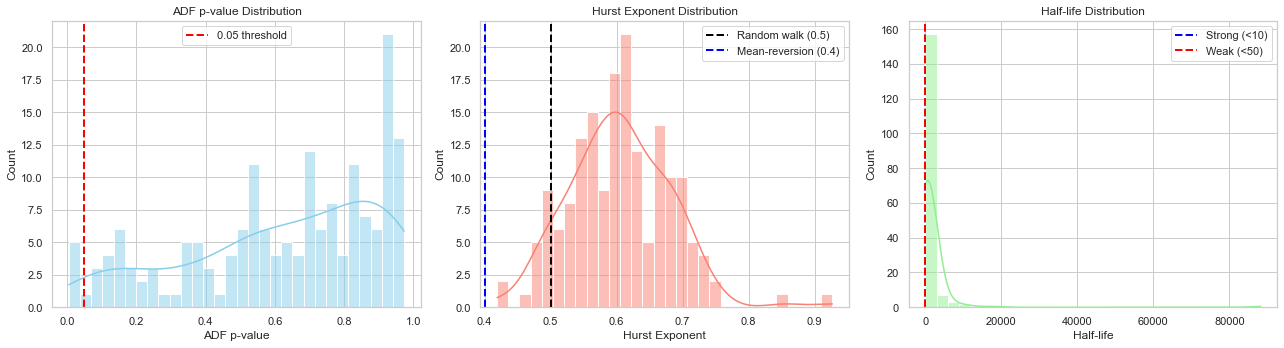

In [10]:
# Plotting histograms for ADF p-value, Hurst exponent, and Half-life
df = df[df['Half-life'] > 0].copy()

# Set style
sns.set(style='whitegrid')

# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for ADF p-value with threshold
sns.histplot(df['ADF p-value'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(0.05, color='red', linestyle='--', linewidth=2, label='0.05 threshold')
axes[0].set_title('ADF p-value Distribution')
axes[0].set_xlabel('ADF p-value')
axes[0].legend()

# Histogram for Hurst exponent with thresholds
sns.histplot(df['Hurst'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Random walk (0.5)')
axes[1].axvline(0.4, color='blue', linestyle='--', linewidth=2, label='Mean-reversion (0.4)')
axes[1].set_title('Hurst Exponent Distribution')
axes[1].set_xlabel('Hurst Exponent')
axes[1].legend()

# Histogram for Half-life with thresholds
sns.histplot(df['Half-life'], bins=30, kde=True, ax=axes[2], color='lightgreen')
axes[2].axvline(10, color='blue', linestyle='--', linewidth=2, label='Strong (<10)')
axes[2].axvline(50, color='red', linestyle='--', linewidth=2, label='Weak (<50)')
axes[2].set_title('Half-life Distribution')
axes[2].set_xlabel('Half-life')
axes[2].legend()

# Final layout
plt.tight_layout()
plt.savefig(f"../modelling_result/plots_individual_distribution")
plt.show()

### 4.2. Backtesting strategy

In [11]:
result_comparision = compare_results(combined_df_report)
result_comparision.head(5)

Count  Sharpe_Mean  Hurst_Mean  \
Mean_Reverting Outperform CapSize                                   
False          False      Large      811     0.098461    0.634738   
                          Mid        472     0.035084    0.617305   
                          Small      578     0.116629    0.626091   
               True       Small       15     0.003785    0.661060   
True           False      Large       32     0.206570    0.471725   

                                   ADF_pval_Mean  Half_life_Mean  Window_mean  \
Mean_Reverting Outperform CapSize                                               
False          False      Large         0.825036   -10840.515366    27.721332   
                          Mid           0.690466     -312.908997    28.735169   
                          Small         0.611508      177.294313    27.384083   
               True       Small         0.338540      294.111960    43.400000   
True           False      Large         0.101819       61.408956    30.656250   

                                   Volatility_Mean  
Mean_Reverting Outperform CapSize                   
False          False      Large           0.015981  
                          Mid             0.023378  
                          Small           0.028862  
               True       Small           0.033127  
True           False      Large           0.016503

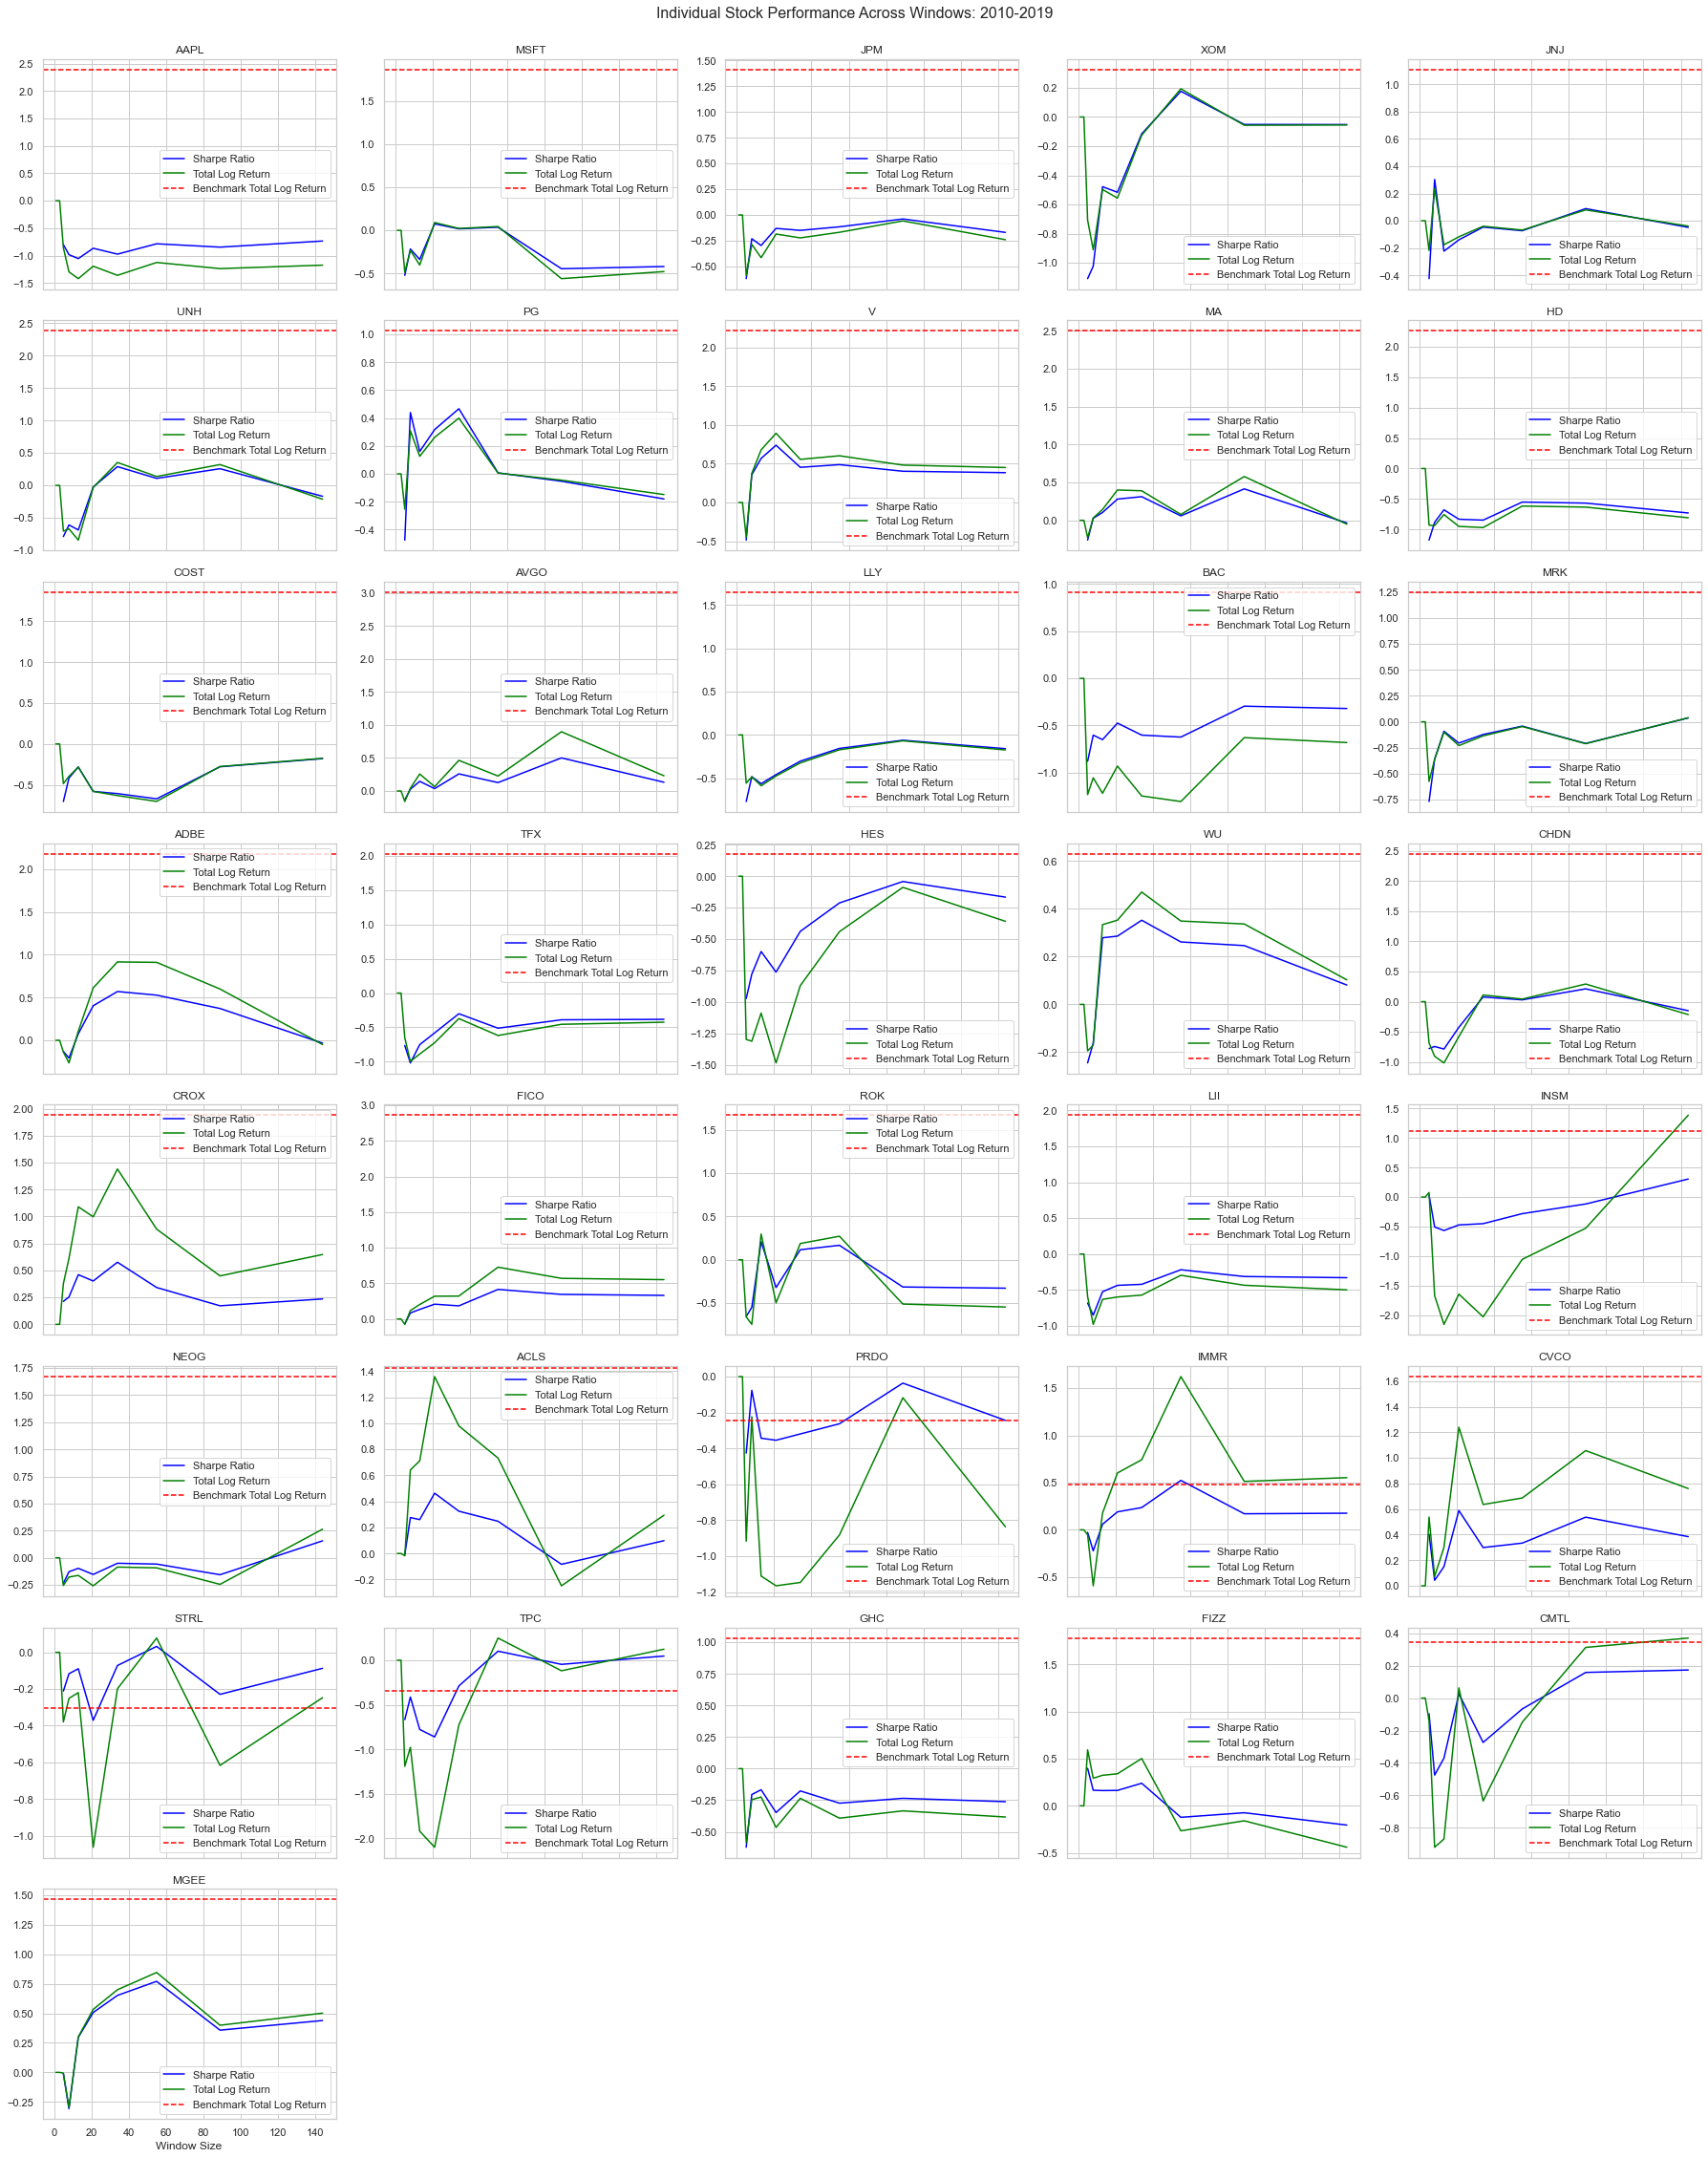

In [12]:
# Plotting results
# Change start_date and end_date to plot results for other timeframes
plot_all_tickers_grid_with_benchmark(df_report, df_report['Ticker'].unique())